## CIFAR 100 Classification

In [1]:
!pip install opendatasets --upgrade -q
import os
import torch, torchvision
import tarfile
import torch.nn as nn
import tqdm.auto as tqdm
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
import opendatasets as od
%matplotlib inline

In [2]:
dataset_url = 'https://www.kaggle.com/minbavel/cifar-100-images'
od.download(dataset_url)
project_name = "CIFAR-100"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shankhs
Your Kaggle Key: ··········


100%|██████████| 140M/140M [00:00<00:00, 156MB/s]


In [3]:
data_dir = './cifar-100-images/CIFAR100'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(len(classes))
print(classes)

['TEST', 'TRAIN']
100
['sea', 'table', 'leopard', 'orchid', 'orange', 'caterpillar', 'girl', 'train', 'lobster', 'willow_tree', 'can', 'tulip', 'lizard', 'cup', 'bus', 'keyboard', 'lawn_mower', 'turtle', 'possum', 'wardrobe', 'raccoon', 'tiger', 'crocodile', 'chair', 'flatfish', 'skunk', 'ray', 'tractor', 'plate', 'hamster', 'otter', 'worm', 'wolf', 'pear', 'clock', 'seal', 'skyscraper', 'snail', 'snake', 'rabbit', 'bed', 'mountain', 'cattle', 'road', 'forest', 'bicycle', 'lamp', 'rocket', 'spider', 'whale', 'poppy', 'boy', 'cloud', 'mouse', 'oak_tree', 'lion', 'dinosaur', 'shrew', 'apple', 'camel', 'castle', 'dolphin', 'aquarium_fish', 'squirrel', 'mushroom', 'trout', 'man', 'plain', 'butterfly', 'sunflower', 'bowl', 'kangaroo', 'elephant', 'streetcar', 'crab', 'fox', 'chimpanzee', 'sweet_pepper', 'bridge', 'baby', 'beetle', 'motorcycle', 'cockroach', 'bottle', 'maple_tree', 'tank', 'television', 'palm_tree', 'pine_tree', 'house', 'shark', 'pickup_truck', 'telephone', 'woman', 'couch'

In [4]:
# Let's evaluate a single class say "man"
man_file=os.listdir(data_dir+"/TRAIN/man")
print("NO. of Training examples for Man:",len(man_file))
print(man_file[:5])

NO. of Training examples for Man: 500
['cain_s_001050.png', 'cain_s_000724.png', 'adam_s_000643.png', 'adam_s_001565.png', 'man_s_000898.png']


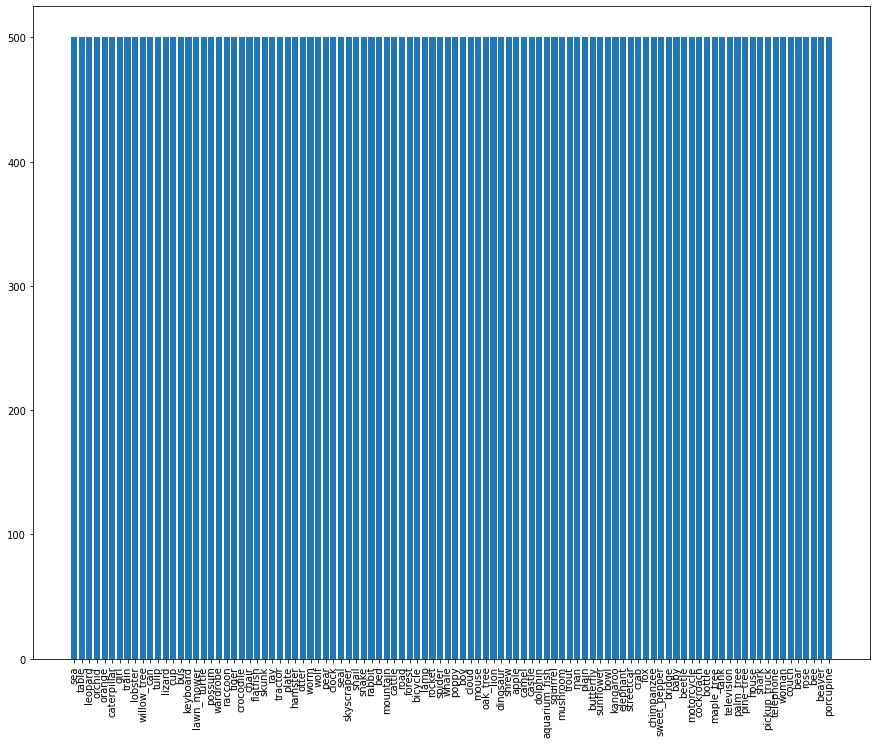

In [5]:
# Let's see how many number of files/images are present in each classes
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+"/TRAIN/"+i))
plt.figure(figsize = (15, 12))
plt.bar(range(len(di)), list(di.values()), align='center')
plt.xticks(range(len(di)), list(di.keys()), rotation = 90)
plt.show()

### Normalization

In [6]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/TRAIN', tt.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

(tensor([0.5071, 0.4865, 0.4409]), tensor([0.2009, 0.1984, 0.2023]))

In [7]:
# Data transforms (normalization & data augmentation)

stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'), 
                         tt.RandomHorizontalFlip(),tt.ToTensor(), tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [8]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/TRAIN', train_tfms)
valid_ds = ImageFolder(data_dir+'/TEST', valid_tfms)

In [9]:
batch_size = 400

In [10]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

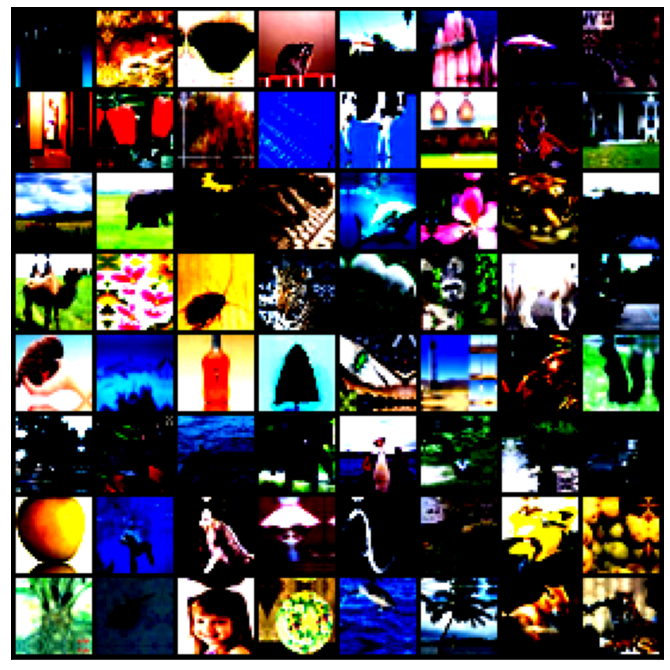

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dl);

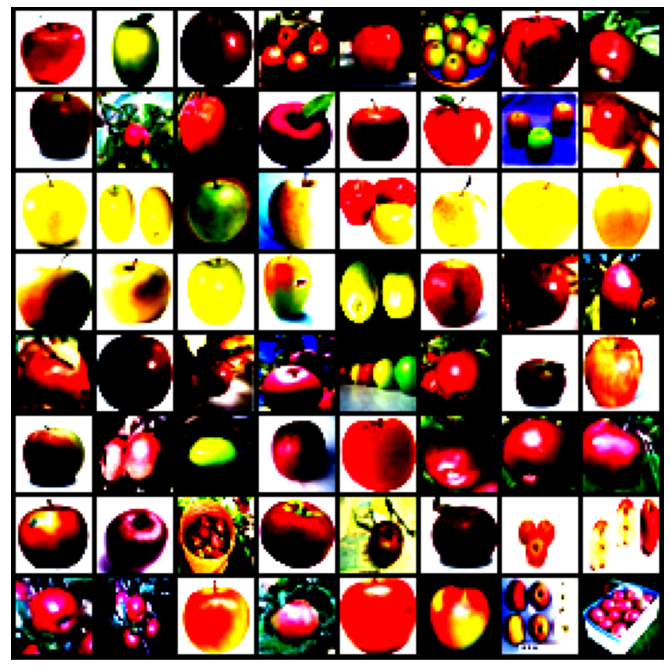

In [12]:
show_batch(valid_dl);

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
# Transfering data to the device in use (In our case GPU)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) # 3 x 32 x 32 -> 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 64 x 32 x 32 -> 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16 -> 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 16 x 16 -> 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 256 x 8 x 8 -> 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4 -> 512 x 4 x 4
        self.conv5 = conv_block(512, 1028, pool=True) # 512 x 4 x 4 -> 1028 x 2 x 2
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  # 1028 x 2 x 2 -> 1028 x 2 x 2
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028 
                                        nn.Linear(1028, num_classes)) # 1028 -> 100
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Train the model

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.606374263763428, 'val_acc': 0.008750000037252903}]

In [21]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay =1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 3.7245, val_loss: 3.7113, val_acc: 0.1838
Epoch [1], last_lr: 0.00759, train_loss: 2.9667, val_loss: 2.9932, val_acc: 0.2759
Epoch [2], last_lr: 0.01000, train_loss: 2.3181, val_loss: 2.4258, val_acc: 0.3854
Epoch [3], last_lr: 0.00950, train_loss: 2.0007, val_loss: 2.7464, val_acc: 0.3623
Epoch [4], last_lr: 0.00812, train_loss: 1.6664, val_loss: 1.9035, val_acc: 0.4984
Epoch [5], last_lr: 0.00611, train_loss: 1.4156, val_loss: 1.6087, val_acc: 0.5545
Epoch [6], last_lr: 0.00389, train_loss: 1.1978, val_loss: 1.4274, val_acc: 0.5935
Epoch [7], last_lr: 0.00188, train_loss: 0.9529, val_loss: 1.1769, val_acc: 0.6593
Epoch [8], last_lr: 0.00050, train_loss: 0.6934, val_loss: 1.0352, val_acc: 0.6977
Epoch [9], last_lr: 0.00000, train_loss: 0.5231, val_loss: 0.9973, val_acc: 0.7106
CPU times: user 1min 59s, sys: 1min 8s, total: 3min 7s
Wall time: 6min 43s


In [23]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00028, train_loss: 0.4950, val_loss: 0.9996, val_acc: 0.7115
Epoch [1], last_lr: 0.00076, train_loss: 0.5102, val_loss: 1.0874, val_acc: 0.6870
Epoch [2], last_lr: 0.00100, train_loss: 0.5371, val_loss: 1.1915, val_acc: 0.6716
Epoch [3], last_lr: 0.00095, train_loss: 0.5098, val_loss: 1.2407, val_acc: 0.6602
Epoch [4], last_lr: 0.00081, train_loss: 0.4222, val_loss: 1.1632, val_acc: 0.6853
Epoch [5], last_lr: 0.00061, train_loss: 0.3284, val_loss: 1.0655, val_acc: 0.7068
Epoch [6], last_lr: 0.00039, train_loss: 0.2376, val_loss: 1.0602, val_acc: 0.7163
Epoch [7], last_lr: 0.00019, train_loss: 0.1670, val_loss: 1.0152, val_acc: 0.7278
Epoch [8], last_lr: 0.00005, train_loss: 0.1264, val_loss: 1.0085, val_acc: 0.7320
Epoch [9], last_lr: 0.00000, train_loss: 0.1100, val_loss: 1.0093, val_acc: 0.7324
CPU times: user 1min 56s, sys: 1min 6s, total: 3min 3s
Wall time: 6min 44s


In [24]:
%%time
history += fit_one_cycle(5, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00008, train_loss: 0.1079, val_loss: 1.0134, val_acc: 0.7311
Epoch [1], last_lr: 0.00010, train_loss: 0.1082, val_loss: 1.0208, val_acc: 0.7300
Epoch [2], last_lr: 0.00006, train_loss: 0.0973, val_loss: 1.0328, val_acc: 0.7300
Epoch [3], last_lr: 0.00002, train_loss: 0.0859, val_loss: 1.0250, val_acc: 0.7307
Epoch [4], last_lr: 0.00000, train_loss: 0.0806, val_loss: 1.0238, val_acc: 0.7328
CPU times: user 58.2 s, sys: 33.4 s, total: 1min 31s
Wall time: 3min 20s


In [25]:
%%time
history += fit_one_cycle(5, 0.00001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.0799, val_loss: 1.0268, val_acc: 0.7315
Epoch [1], last_lr: 0.00001, train_loss: 0.0801, val_loss: 1.0223, val_acc: 0.7324
Epoch [2], last_lr: 0.00001, train_loss: 0.0777, val_loss: 1.0219, val_acc: 0.7337
Epoch [3], last_lr: 0.00000, train_loss: 0.0765, val_loss: 1.0233, val_acc: 0.7324
Epoch [4], last_lr: 0.00000, train_loss: 0.0758, val_loss: 1.0230, val_acc: 0.7333
CPU times: user 58.8 s, sys: 34.3 s, total: 1min 33s
Wall time: 3min 20s


In [26]:
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 0.0767, val_loss: 1.0272, val_acc: 0.7315
Epoch [1], last_lr: 0.00008, train_loss: 0.0763, val_loss: 1.0332, val_acc: 0.7308
Epoch [2], last_lr: 0.00010, train_loss: 0.0770, val_loss: 1.0427, val_acc: 0.7303
Epoch [3], last_lr: 0.00010, train_loss: 0.0717, val_loss: 1.0555, val_acc: 0.7293
Epoch [4], last_lr: 0.00008, train_loss: 0.0654, val_loss: 1.0589, val_acc: 0.7311
Epoch [5], last_lr: 0.00006, train_loss: 0.0577, val_loss: 1.0626, val_acc: 0.7325
Epoch [6], last_lr: 0.00004, train_loss: 0.0515, val_loss: 1.0634, val_acc: 0.7322
Epoch [7], last_lr: 0.00002, train_loss: 0.0474, val_loss: 1.0671, val_acc: 0.7320
Epoch [8], last_lr: 0.00000, train_loss: 0.0455, val_loss: 1.0657, val_acc: 0.7333
Epoch [9], last_lr: 0.00000, train_loss: 0.0437, val_loss: 1.0678, val_acc: 0.7331
CPU times: user 1min 59s, sys: 1min 10s, total: 3min 10s
Wall time: 6min 40s


In [27]:
# Plotted the accuracy graph
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize = (12, 8))
    plt.plot(accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

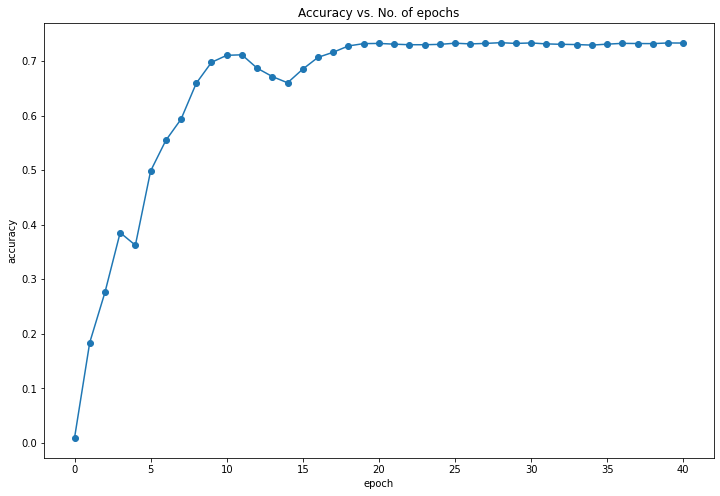

In [28]:
plot_accuracies(history)

In [29]:
# Training and Validation loss graph
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure(figsize = (12, 8))
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs')

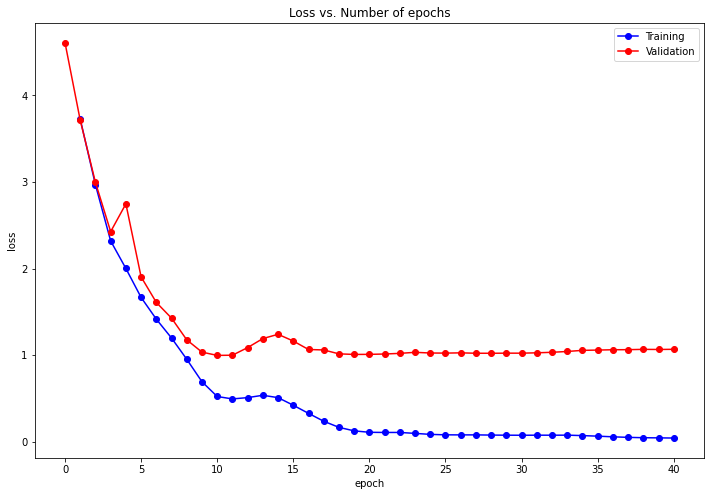

In [30]:
plot_losses(history)

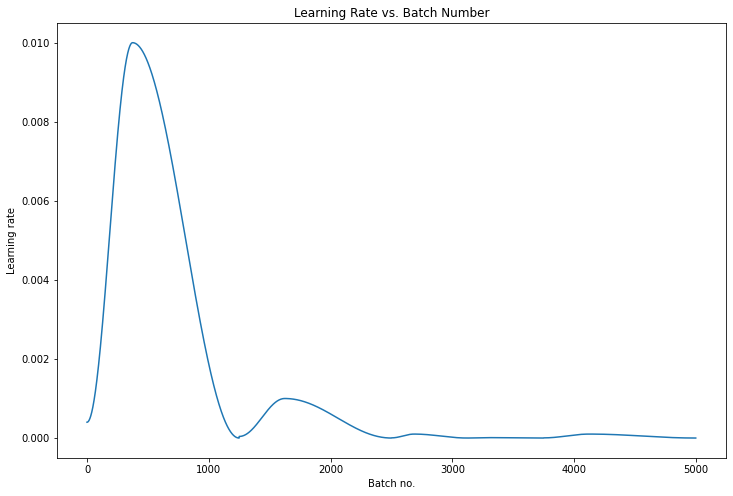

In [31]:
# Learning Rate Graph
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.figure(figsize = (12, 8))
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch Number');

plot_lrs(history)

### Prediction and testing

In [32]:
from torchvision.transforms import ToTensor
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
test_dataset = ImageFolder(data_dir+'/TEST', test_tfms)

dataset = ImageFolder(data_dir+'/TRAIN', transform=ToTensor())

In [33]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: bed , Predicted: bed


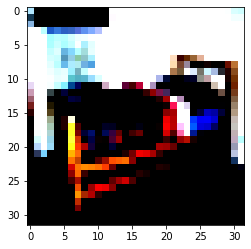

In [34]:
img, label = test_dataset[550]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: apple , Predicted: apple


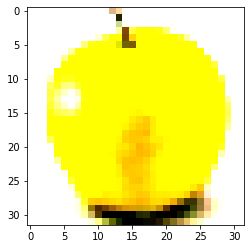

In [35]:
img, label = test_dataset[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: aquarium_fish , Predicted: aquarium_fish


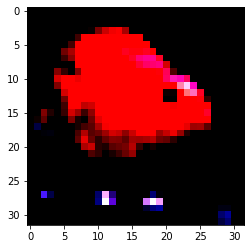

In [36]:
img, label = test_dataset[117]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: baby , Predicted: baby


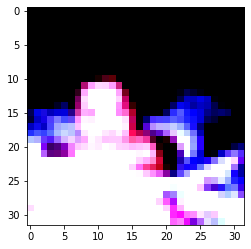

In [37]:
img, label = test_dataset[210]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: bed , Predicted: streetcar


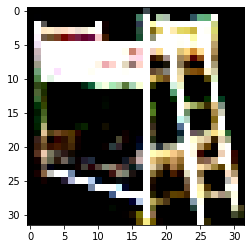

In [38]:
img, label = test_dataset[589]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [39]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.067769169807434, 'val_acc': 0.733076810836792}

In [40]:
torch.save(model.state_dict(), 'cifar100-resnet12layers.pth')
model2 = to_device(ResNet9(3, 100), device)

In [41]:
model2.load_state_dict(torch.load('cifar100-resnet12layers.pth'))
evaluate(model2, test_loader)

{'val_loss': 1.067769169807434, 'val_acc': 0.733076810836792}